# 3. Audio Features (6 points):
**Load and analyze the audio features:**

In [19]:
import os
import math

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler

In [20]:
# CONFIGURATION
PATH_TO_DATASET = '../MLPC2025_dataset'
METADATA_CSV = os.path.join(PATH_TO_DATASET, "metadata.csv")
ANNOTATIONS_CSV = os.path.join(PATH_TO_DATASET, "annotations.csv")
AUDIO_FEATURE_FOLDER = os.path.join(PATH_TO_DATASET, "audio_features")

**Feature Variance**

(a) Which audio features appear useful? Select only the most relevant ones or perform a down projection
for the next steps.

In [21]:
meta_df = pd.read_csv(os.path.join(PATH_TO_DATASET, METADATA_CSV))
meta_df.set_index("filename",inplace=True)

an_df = pd.read_csv(os.path.join(PATH_TO_DATASET, ANNOTATIONS_CSV))
an_df.set_index("filename",inplace=True)

an_df["duration"] = an_df["offset"] - an_df["onset"]

In [22]:
def load_audio_features(feature_key="embeddings", file_list=None, folder=AUDIO_FEATURE_FOLDER):
    audio_features = {}

    for file in os.listdir(folder):
        if file.endswith(".npz"):
            file_path = os.path.join(folder, file)
            filename = file.replace(".npz", ".mp3")
            
            if file_list is not None and filename not in file_list:
                continue  # skip if not in the metadata list
            
            try:
                data = np.load(file_path)
                if feature_key in data:
                    audio_features[filename] = data[feature_key]
                else:
                    print(f"Feature '{feature_key}' not found in {file}")
            except Exception as e:
                print(f"Error loading {file}: {e}")
    
    print(f"Loaded '{feature_key}' features for:", len(audio_features), "files")
    return audio_features

Text(0.5, 1.0, 'melspectogram of audio 554659')

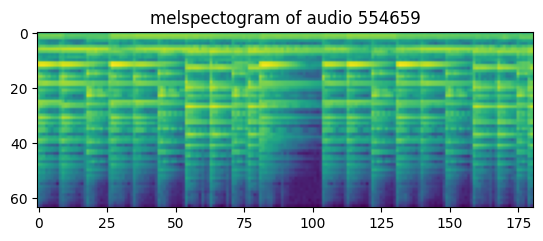

In [23]:
feature_names = ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2","flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]
plt.imshow(np.load(os.path.join(AUDIO_FEATURE_FOLDER, "554659.npz"))["melspectrogram"].T)
plt.title("melspectogram of audio 554659")

In [24]:
features = {}
for i in feature_names:
    features[i] = []

for i in feature_names:
    for idx, row in meta_df.iterrows():
        file_name = idx.replace("mp3", "npz")
        path_to_feature_file = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
        feature = np.load(path_to_feature_file)[i]
        features[i].append(feature)

In [25]:
len(features["power"])

9026

In [26]:
feature_variance = {}
for i in features:
    feature_variance[i] = []

for i in  features.keys():
    all_data = np.concatenate(features[i], axis=0) 
    var_vector = np.var(all_data, axis=0)  
    mean_var=np.mean(var_vector)
    feature_variance[i] = mean_var  
feature_variance

{'embeddings': np.float32(0.16439807),
 'melspectrogram': np.float32(4.104725),
 'mfcc': np.float32(8.133642),
 'mfcc_delta': np.float32(0.037693016),
 'mfcc_delta2': np.float32(0.011817663),
 'flatness': np.float32(0.008108149),
 'centroid': np.float64(911897.7522526988),
 'bandwidth': np.float64(553391.9807078558),
 'flux': np.float32(233.33109),
 'contrast': np.float64(21.883677801343833),
 'energy': np.float32(27580.387),
 'zerocrossingrate': np.float64(0.01563705663770939),
 'power': np.float32(8344511.5)}

In [27]:
def summarize_feature(feature_list, agg_func=np.mean):
    """Summarize each sample in a feature list using agg_func (mean, var, etc.)"""
    return [agg_func(sample) if isinstance(sample, (np.ndarray, list)) else sample
            for sample in feature_list]

# 2. Build a summary DataFrame
summary_dict = {}
for feature_name, sample_list in features.items():
    summary_dict[feature_name] = summarize_feature(sample_list, agg_func=np.mean)  # or np.var, np.median, etc.

df_summary = pd.DataFrame(summary_dict)
corr_matrix = df_summary.corr()

In [28]:
feature_variance["index"]=[0]
feature_variance["index"]
var_df = pd.DataFrame.from_dict(feature_variance)
var_df

,embeddings,melspectrogram,mfcc,mfcc_delta,mfcc_delta2,flatness,centroid,bandwidth,flux,contrast,energy,zerocrossingrate,power,index
0,0.164398,4.104725,8.133642,0.037693,0.011818,0.008108,911897.752253,553391.980708,233.331085,21.883678,27580.386719,0.015637,8344511.5,0


Text(0.5, 1.0, 'variance of single dimesional features')

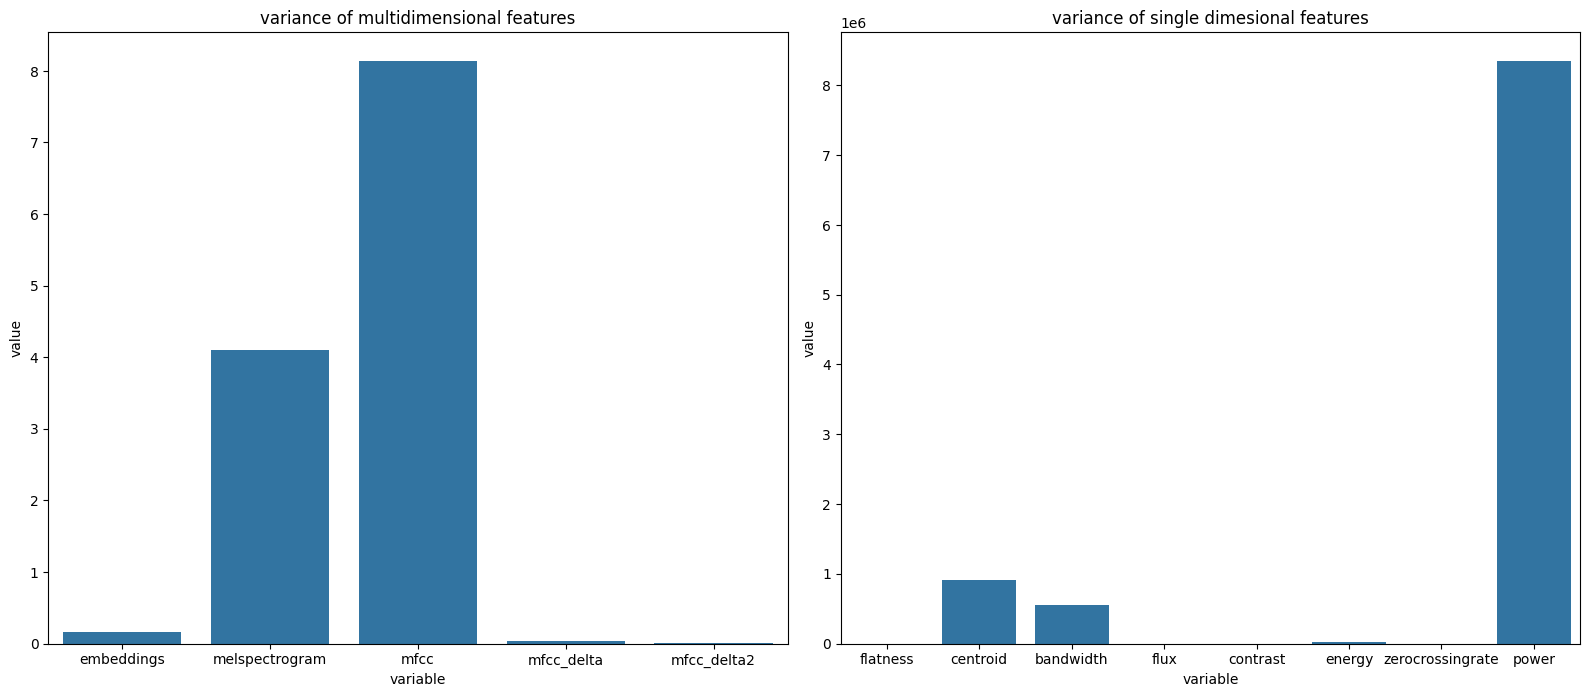

In [29]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
plot_df1 = var_df[["embeddings", "melspectrogram", "mfcc", "mfcc_delta", "mfcc_delta2"]].melt()
plot_df2= var_df[["flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]].melt()
sns.barplot(data=plot_df1,x="variable",y="value",ax=ax[0])
sns.barplot(data=plot_df2,x="variable",y="value",ax=ax[1])
plt.tight_layout()
ax[0].set_title("variance of multidimensional features")
ax[1].set_title("variance of single dimesional features")

<Axes: >

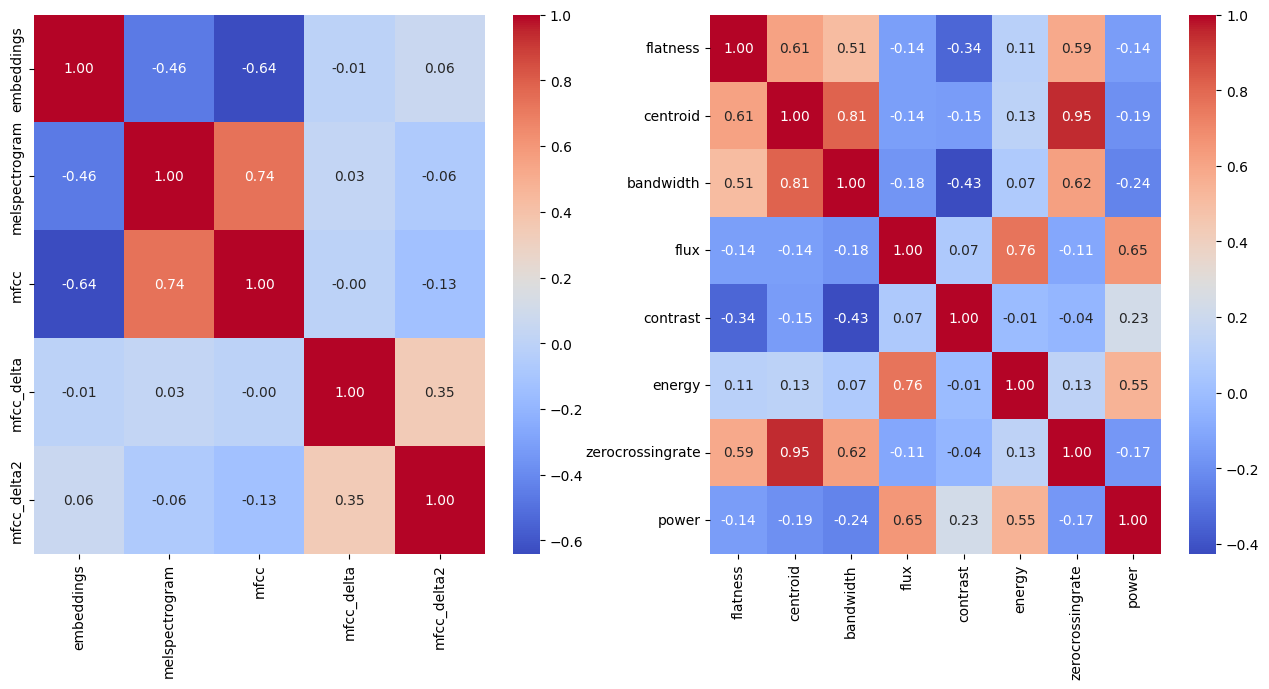

In [30]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
selected= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2"]
s = ["flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]
sns.heatmap(corr_matrix.loc[selected, selected], annot=True, cmap='coolwarm', fmt=".2f",ax=ax[0])
sns.heatmap(corr_matrix.loc[s, s], annot=True, cmap='coolwarm', fmt=".2f",ax=ax[1])

most usefull audio features based on their variance and correlation are:



multidimensional: mfcc & melspectogram are the most informative multidimensionl features according to their variance,however using both of them to train the model makes them redundant feature hence their high corellation.


single dimensional: power & centroid  are the most informative multidimensionl features according to their variance and since they have a low corelation score they capture independent information so they are infact  not redundant

(b) Extract a fixed-length feature vector for each annotated region as well as for all the silent parts in
between. The most straightforward way to do this is to average the audio features of the corresponding
region over time, as shown in the tutorial session.

In [31]:
N_CLUSTERS = 20
#HOP_LENGTH = 512
#SR = x # sampling rate
RESOLUTION = 0.12 # mode of temporal resolution of the features is 120ms per step

FEATURE_KEYS = {
    "mfcc": "multi",
    "melspectrogram": "multi",
    "power": "single",
    "centroid": "single",
}

In [32]:
annotations = pd.read_csv(ANNOTATIONS_CSV)
print("Annotations loaded:", annotations.shape)

audio_features = load_audio_features("mfcc", file_list=meta_df.index)

# Standardize (fit on all data)
concatenated = np.concatenate(list(audio_features.values()), axis=0)
scaler = preprocessing.StandardScaler().fit(concatenated)
del concatenated  # we no longer need it

def get_features_of_annotation(
    onset: float, 
    offset: float, 
    features, 
    scaler: preprocessing.StandardScaler = None
) -> np.ndarray:
    
    start_idx = math.floor(onset / RESOLUTION)
    end_idx = math.ceil(offset / RESOLUTION)
    
    segment = features[start_idx:end_idx]
    if segment.shape[0] == 0:
        return None
    if scaler is not None:
        segment = scaler.transform(segment)
    return segment.mean(axis=0)

# Extract fixed-length vectors for annotated and silent regions
X = []
region_labels = []

for filename in annotations["filename"].unique():
    if filename not in audio_features:
        print(f"Missing features for {filename}")
        continue

    features = audio_features[filename]
    total_frames = features.shape[0]
    total_duration = total_frames * RESOLUTION

    file_annots = annotations[annotations["filename"] == filename]
    time_regions = []

    # Annotated segments
    for _, row in file_annots.iterrows():
        feat = get_features_of_annotation(row["onset"], row["offset"], features, scaler)
        if feat is not None:
            X.append(feat)
            region_labels.append("annotated")
            time_regions.append((row["onset"], row["offset"]))

    # Silent regions (gaps between annotations)
    time_regions = sorted(time_regions)
    prev_end = 0.0
    for onset, offset in time_regions:
        if onset > prev_end:
            silent_feat = get_features_of_annotation(prev_end, onset, features, scaler)
            if silent_feat is not None:
                X.append(silent_feat)
                region_labels.append("silent")
        prev_end = max(prev_end, offset)

    # Trailing silence (after last annotation)
    if prev_end < total_duration:
        silent_feat = get_features_of_annotation(prev_end, total_duration, features, scaler)
        if silent_feat is not None:
            X.append(silent_feat)
            region_labels.append("silent")

# Final formatting
X = np.stack(X)
region_labels = np.array(region_labels)

print("Extracted features shape:", X.shape)
print("Region labels:", pd.Series(region_labels).value_counts())

# Final feature scaling
X_scaled = scaler.transform(X)  # Apply same scaler used earlier

print("X_scaled shape:", X_scaled.shape)

Annotations loaded: (35826, 7)
Loaded 'mfcc' features for: 9026 files
Extracted features shape: (57218, 32)
Region labels: annotated    35826
silent       21392
Name: count, dtype: int64
X_scaled shape: (57218, 32)


(c) Cluster the audio features for the extracted regions.

In [33]:
# CLUSTERING
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
cluster_ids = kmeans.fit_predict(X_scaled)

Can you identify meaningful clusters of audio
features? Do the feature vectors of the silent regions predominantly fall into one large cluster?

In [34]:
# ANALYZING SILENT CLUSTERS
silent_cluster_ids = [cluster_ids[i] for i, label in enumerate(region_labels) if label == "silent"]
silent_counts = Counter(silent_cluster_ids)

print("Silent region cluster distribution:")
for cluster_id, count in sorted(silent_counts.items()):
    print(f"Cluster {cluster_id}: {count} silent regions")

Silent region cluster distribution:
Cluster 0: 41 silent regions
Cluster 1: 1235 silent regions
Cluster 2: 672 silent regions
Cluster 3: 2678 silent regions
Cluster 4: 3800 silent regions
Cluster 5: 211 silent regions
Cluster 6: 1519 silent regions
Cluster 7: 186 silent regions
Cluster 8: 180 silent regions
Cluster 9: 1448 silent regions
Cluster 10: 2010 silent regions
Cluster 11: 182 silent regions
Cluster 12: 178 silent regions
Cluster 13: 553 silent regions
Cluster 14: 299 silent regions
Cluster 15: 5732 silent regions
Cluster 16: 88 silent regions
Cluster 17: 149 silent regions
Cluster 18: 120 silent regions
Cluster 19: 111 silent regions


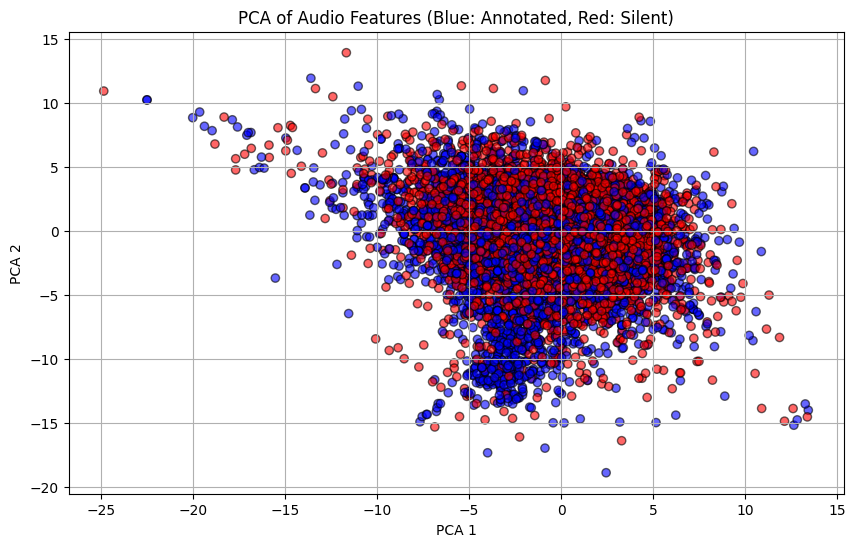

C:\Users\jeron\AppData\Local\Temp\ipykernel_38876\1532404975.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', N_CLUSTERS)


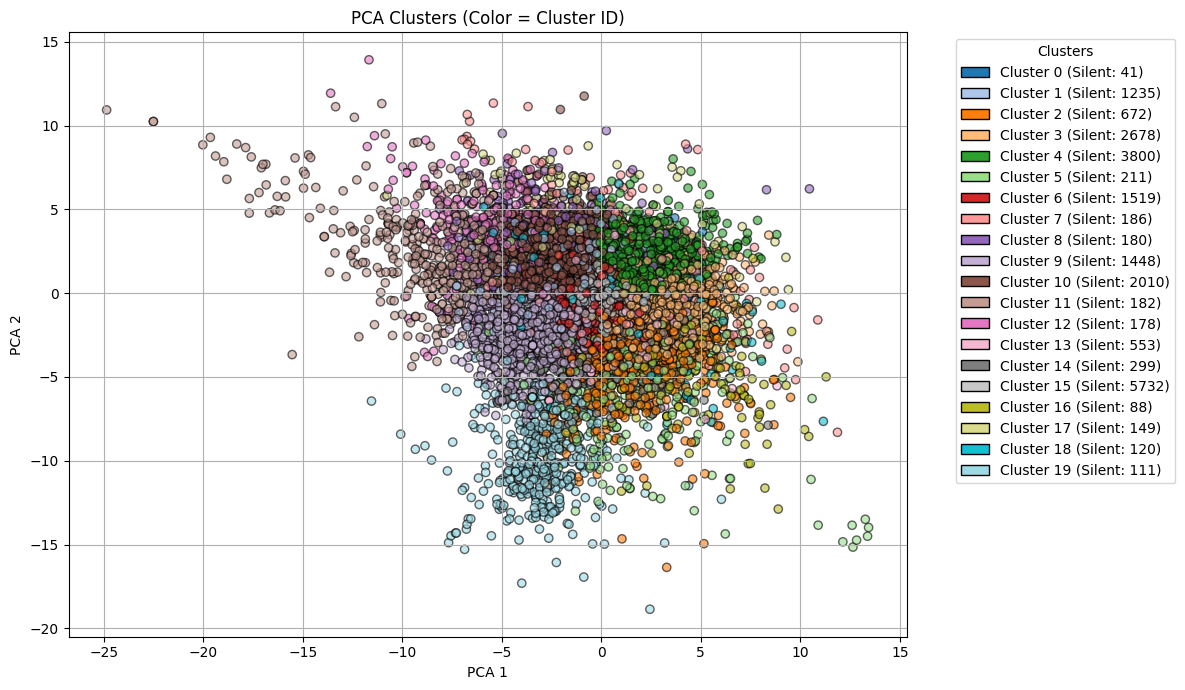

In [35]:
#VISUALIZING PCA CLUSTERS
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

color_map = {'annotated': 'blue', 'silent': 'red'}
colors = [color_map[label] for label in region_labels]

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, edgecolor='k')
plt.title("PCA of Audio Features (Blue: Annotated, Red: Silent)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

colormap = cm.get_cmap('tab20', N_CLUSTERS)
cluster_colors = [colormap(c) for c in cluster_ids]

plt.figure(figsize=(12, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_colors, alpha=0.6, edgecolor='k')
plt.title("PCA Clusters (Color = Cluster ID)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

legend_elements = []
for cluster_id in range(N_CLUSTERS):
    color = colormap(cluster_id)
    count = silent_counts.get(cluster_id, 0)
    label = f"Cluster {cluster_id} (Silent: {count})"
    legend_elements.append(Patch(facecolor=color, edgecolor='k', label=label))

plt.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

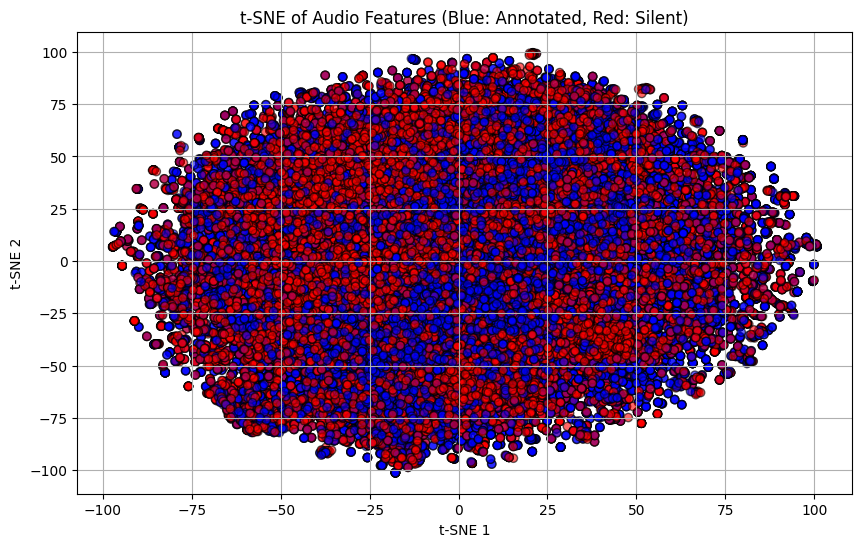

C:\Users\jeron\AppData\Local\Temp\ipykernel_38876\2905538362.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', N_CLUSTERS)


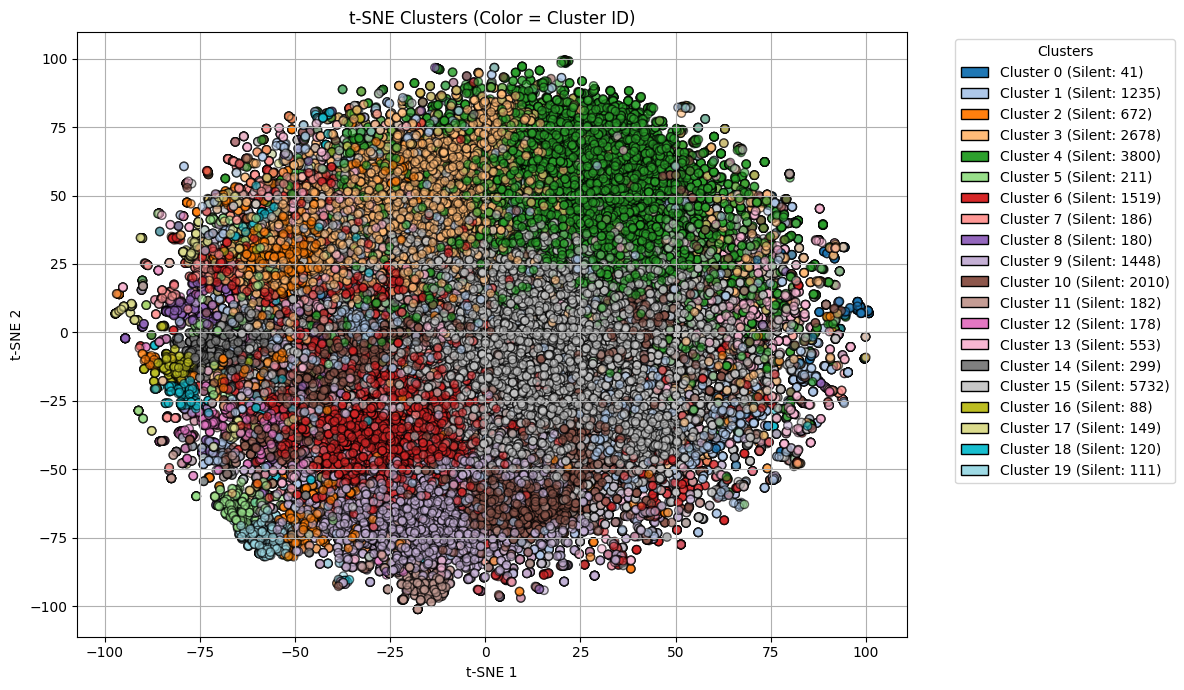

In [36]:
#VISUALIZING t-SNE CLUSTERS
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

color_map = {'annotated': 'blue', 'silent': 'red'}
label_colors = [color_map[label] for label in region_labels]

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label_colors, alpha=0.6, edgecolor='k')
plt.title("t-SNE of Audio Features (Blue: Annotated, Red: Silent)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

if isinstance(cluster_ids, tuple):
    cluster_ids = cluster_ids[0]

colormap = cm.get_cmap('tab20', N_CLUSTERS)
cluster_colors = [colormap(c) for c in cluster_ids]

plt.figure(figsize=(12, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_colors, alpha=0.6, edgecolor='k')
plt.title("t-SNE Clusters (Color = Cluster ID)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)

legend_elements = []
for cluster_id in range(N_CLUSTERS):
    color = colormap(cluster_id)
    count = silent_counts.get(cluster_id, 0)
    label = f"Cluster {cluster_id} (Silent: {count})"
    legend_elements.append(Patch(facecolor=color, edgecolor='k', label=label))

plt.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()